### Importing libraries

In [99]:
# pandas for data structures and operations for manipulating numerical tables and time series
import pandas as pd
from pandas.plotting import scatter_matrix

# matplotlib.pyplot for data plots
import matplotlib.pyplot as plt

# seaborn for statistical data visualization
import seaborn as sns

# sklearn for machine learning methods
from sklearn import tree
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import linear_kernel

# for numeric calculations
import numpy as np
from scipy.sparse import coo_matrix

#for saving files
import os

## 1) Loading data

### Movies

In [100]:
movies = pd.read_csv('./ml-latest-small/movies.csv', index_col=None, na_values=['NA'])

In [101]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [102]:
movies.shape

(9742, 3)

In [103]:
movies['movieId'].max()

193609

### Ratings

In [104]:
ratings = pd.read_csv('./ml-latest-small/ratings.csv', index_col=None, na_values=['NA'])

In [105]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [106]:
ratings.shape

(100836, 4)

## 2) Aggregating data

In [107]:
mvrt = pd.merge(ratings, movies, on='movieId')

In [108]:
mvrt.sample(20)

,userId,movieId,rating,timestamp,title,genres
63008,95,3070,3.0,1105401136,Adventures of Buckaroo Banzai Across the 8th D...,Adventure|Comedy|Sci-Fi
99668,514,184987,3.0,1533947024,A Wrinkle in Time (2018),Adventure|Children|Fantasy|Sci-Fi
32560,83,505,0.5,1332839297,North (1994),Comedy
41517,414,8529,4.0,1089129104,"Terminal, The (2004)",Comedy|Drama|Romance
79523,298,4255,3.0,1447599313,Freddy Got Fingered (2001),Comedy
1624,129,260,4.0,1167375413,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
41443,10,7458,5.0,1455356656,Troy (2004),Action|Adventure|Drama|War
35750,330,4886,5.0,1285905314,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy
74598,599,471,2.5,1498518822,"Hudsucker Proxy, The (1994)",Comedy
36297,307,5218,2.5,1186162434,Ice Age (2002),Adventure|Animation|Children|Comedy


In [109]:
mvrt.shape

(100836, 6)

## 3) Cleaning data

We have loaded and aggregated the data we want to use. Next we will prepare by cleaning the data.

In [110]:
print("--- Missing values: ---")
print(mvrt.isnull().sum())

print("--- NaN values: -------")
print(mvrt.isna().sum())

--- Missing values: ---
userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
dtype: int64
--- NaN values: -------
userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
dtype: int64


We can see that there are no missing or NaN values.

In [111]:
all_genres = movies['genres'].str.split('|', expand=True).stack()
unique_genres_movies = all_genres.value_counts()
print("Number of occurrences for each genre:")
print(unique_genres_movies)

Number of occurrences for each genre:
Drama                 4361
Comedy                3756
Thriller              1894
Action                1828
Romance               1596
Adventure             1263
Crime                 1199
Sci-Fi                 980
Horror                 978
Fantasy                779
Children               664
Animation              611
Mystery                573
Documentary            440
War                    382
Musical                334
Western                167
IMAX                   158
Film-Noir               87
(no genres listed)      34
Name: count, dtype: int64


By looking at the number of occurrences for each genre, we can se there is 34 occurrences with no genres listed, we are going to remove movies without listed genres.

In [112]:
rows_with_no_genre = mvrt[mvrt['genres'] == '(no genres listed)']

In [113]:
rows_with_no_genre.movieId.value_counts()

movieId
122896    7
141866    3
142456    2
152037    2
166024    2
171495    2
172591    2
147250    1
171749    1
132084    1
181719    1
141131    1
156605    1
122888    1
174403    1
165489    1
182727    1
149330    1
143410    1
129250    1
167570    1
176601    1
172497    1
114335    1
169034    1
159779    1
181413    1
155589    1
171891    1
171631    1
159161    1
134861    1
173535    1
161008    1
Name: count, dtype: int64

In [114]:
mvrt = mvrt[~mvrt['movieId'].isin(rows_with_no_genre['movieId'])]
movies = movies[~movies['movieId'].isin(rows_with_no_genre['movieId'])]

In [115]:
mvrt.shape

(100789, 6)

In [116]:
all_genres = movies['genres'].str.split('|', expand=True).stack()
unique_genres = all_genres.value_counts()
print("Number of occurrences for each genre:")
print(unique_genres)

Number of occurrences for each genre:
Drama          4361
Comedy         3756
Thriller       1894
Action         1828
Romance        1596
Adventure      1263
Crime          1199
Sci-Fi          980
Horror          978
Fantasy         779
Children        664
Animation       611
Mystery         573
Documentary     440
War             382
Musical         334
Western         167
IMAX            158
Film-Noir        87
Name: count, dtype: int64


Now we can see that we have succesfully gotten rid of movies with no listed genres.

Let's remove year from the title of the movie and give it it's own column.

In [117]:
mvrt['year_released'] = mvrt['title'].str.extract(r'\((\d{4})\)', expand=False)
mvrt['title'] = mvrt['title'].str.replace(r'\s*\(\d{4}\)\s*', '', regex=True)

In [118]:
mvrt.head()

,userId,movieId,rating,timestamp,title,genres,year_released
0,1,1,4.0,964982703,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,5,1,4.0,847434962,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
2,7,1,4.5,1106635946,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
3,15,1,2.5,1510577970,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
4,17,1,4.5,1305696483,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995


In [119]:
mvrt.isnull().sum()

userId           0
movieId          0
rating           0
timestamp        0
title            0
genres           0
year_released    8
dtype: int64

We can see that 8 movies have no release year.

Checking what movies has no release year.

In [120]:
mvrt_movies_with_no_year = mvrt[mvrt['year_released'].isnull()]
mvrt_movies_with_no_year

,userId,movieId,rating,timestamp,title,genres,year_released
93457,209,140956,3.5,1524522239,Ready Player One,Action|Sci-Fi|Thriller,NaN
93458,305,140956,4.5,1533043577,Ready Player One,Action|Sci-Fi|Thriller,NaN
93459,380,140956,3.0,1534176158,Ready Player One,Action|Sci-Fi|Thriller,NaN
93460,514,140956,3.0,1533946119,Ready Player One,Action|Sci-Fi|Thriller,NaN
93476,210,40697,4.0,1527266191,Babylon 5,Sci-Fi,NaN
93477,528,40697,0.5,1391736467,Babylon 5,Sci-Fi,NaN
96413,306,149334,3.0,1518380372,Nocturnal Animals,Drama|Thriller,NaN
99001,462,162414,5.0,1478489531,Moonlight,Drama,NaN


We are adding the missing release years on our own.

In [121]:
#giving the movies with no release year the correct year.
mvrt.loc[mvrt['title'] == 'Ready Player One', 'year_released'] = 2018
mvrt.loc[mvrt['title'] == 'Babylon 5', 'year_released'] = 1994
mvrt.loc[mvrt['title'] == 'Nocturnal Animals', 'year_released'] = 2016
mvrt.loc[mvrt['title'] == 'Moonlight', 'year_released'] = 2016

In [122]:
#checking that movies with no year now is empty
mvrt_movies_with_no_year1 = mvrt[pd.isna(mvrt['year_released'])]
mvrt_movies_with_no_year1.shape

(0, 7)

In [123]:
mvrt.drop(columns=['timestamp'], inplace=True)

In [124]:
mvrt.sample(3)

,userId,movieId,rating,title,genres,year_released
49955,520,4973,5.0,"Amelie (Fabuleux destin d'Amélie Poulain, Le)",Comedy|Romance,2001
60053,198,1690,2.0,Alien: Resurrection,Action|Horror|Sci-Fi,1997
86710,89,89898,3.5,Generation P,Comedy|Drama|Sci-Fi,2011


In [125]:
mvrt.dtypes

userId             int64
movieId            int64
rating           float64
title             object
genres            object
year_released     object
dtype: object

In [126]:
#converting year released into numeric and not an object
mvrt['year_released'] = pd.to_numeric(mvrt['year_released'], errors='coerce')
mvrt.dtypes

userId             int64
movieId            int64
rating           float64
title             object
genres            object
year_released      int64
dtype: object

## 4) Exploring data

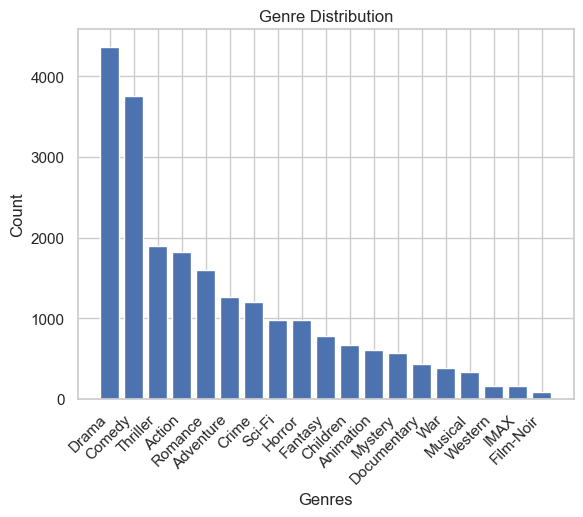

In [127]:
plt.bar(unique_genres.index, unique_genres)
plt.xlabel('Genres')
plt.ylabel('Count')
plt.title('Genre Distribution')
plt.xticks(rotation=45, ha='right')
plt.show()

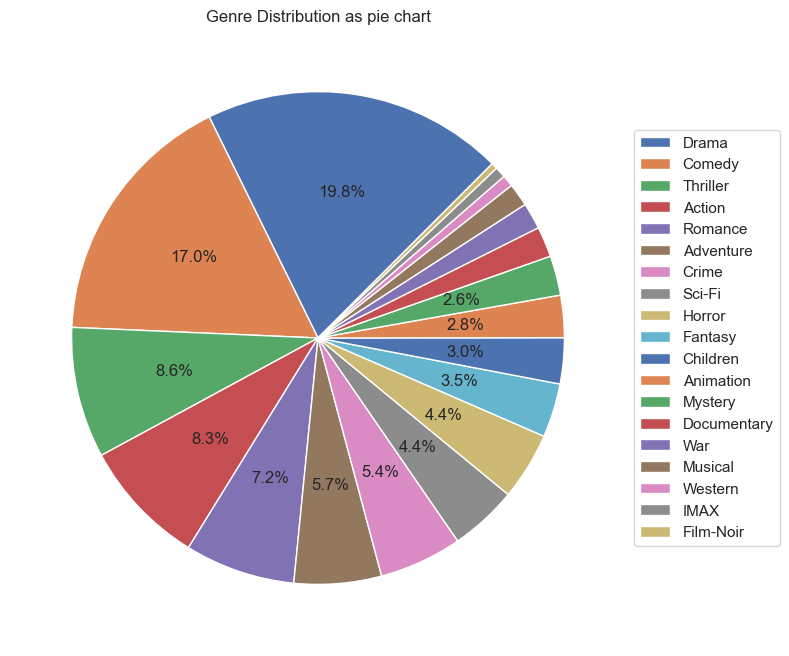

In [128]:
threshold = 2
filtered_genres = unique_genres[unique_genres >= threshold]
plt.figure(figsize=(10, 8))
patches, _, autotexts = plt.pie(filtered_genres, labels=None, autopct=lambda p: f'{p:.1f}%' if p >= threshold else '',
                                startangle=45, labeldistance=1.1)
plt.legend(patches, filtered_genres.index, loc="center left", bbox_to_anchor=(1, 0.5))
plt.title('Genre Distribution as pie chart')
plt.show()

This is the distribution of the genres in the dataset. The most common genre is Drama, followed by Comedy and Thriller.

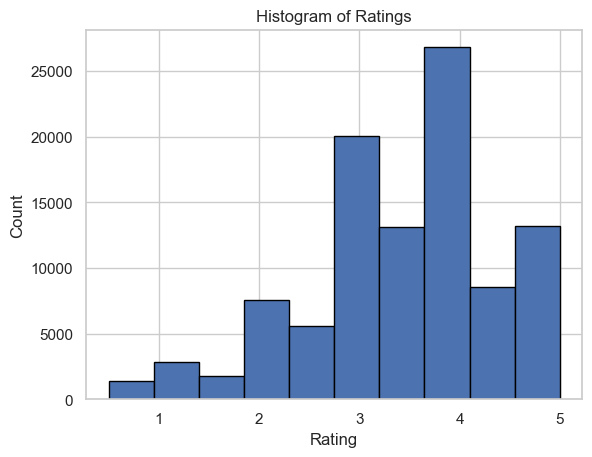

In [129]:
plt.hist(mvrt['rating'], bins=10, edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Histogram of Ratings')
plt.show()

Here we can see that the most common rating is 4.0, and the least common is 0.5.

In [130]:
genres_list = ['Drama', 'Comedy', 'Action', 'Thriller', 'Adventure', 'Romance',
               'Sci-Fi', 'Crime', 'Fantasy', 'Children', 'Mystery', 'Horror',
               'Animation', 'War', 'IMAX', 'Musical', 'Western', 'Documentary', 'Film-Noir']

In [131]:
def average_rating_by_genre(data, genre_list):
    
    #one-hot encoding the genres
    genres_expanded = data['genres'].str.get_dummies(sep='|')
    
    #merging the normal dataset and the encoded
    data_genres = pd.concat([data, genres_expanded], axis=1)
    
    #calculating the average rating of each genre
    average_ratings = {}
    for genre in genre_list:
        if genre in data_genres.columns:
            average_rating = data_genres[data_genres[genre] == 1]['rating'].mean()
            average_ratings[genre] = average_rating

    return average_ratings

In [132]:
result = average_rating_by_genre(mvrt,genres_list)
result

{'Drama': 3.6561844113718758,
 'Comedy': 3.3847207640898267,
 'Action': 3.447984331646809,
 'Thriller': 3.4937055799183425,
 'Adventure': 3.5086089151939075,
 'Romance': 3.5065107040388437,
 'Sci-Fi': 3.455721162210752,
 'Crime': 3.658293867274144,
 'Fantasy': 3.4910005070136894,
 'Children': 3.412956125108601,
 'Mystery': 3.632460255407871,
 'Horror': 3.258195034974626,
 'Animation': 3.6299370349170004,
 'War': 3.8082938876312,
 'IMAX': 3.618335343787696,
 'Musical': 3.5636781053649105,
 'Western': 3.583937823834197,
 'Documentary': 3.797785069729286,
 'Film-Noir': 3.920114942528736}

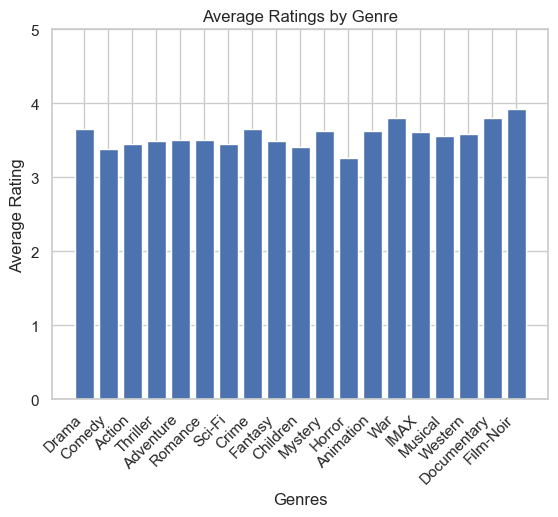

In [133]:
plt.bar(result.keys(), result.values())
plt.xlabel('Genres')
plt.ylabel('Average Rating')
plt.title('Average Ratings by Genre')
plt.ylim(0, 5)  # Set the y-axis limit to 5
plt.xticks(rotation=45, ha='right')  #for better visibility
plt.show()

Here we have the average rating for each genre. The highest average rating is for Film-Noir and the lowest is for Horror.

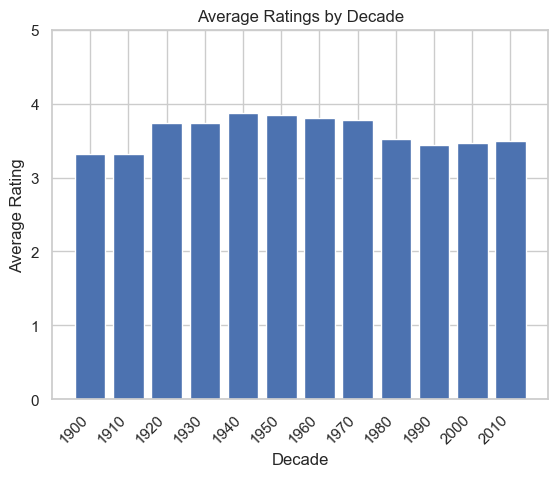

In [134]:
#Creating a column called decade and giving it the correct decade
mvrt['decade'] = (mvrt['year_released'] // 10) * 10
#checking average rating by decade so we can see when we made the best movies
average_ratings_by_decade = mvrt.groupby('decade')['rating'].mean()
#plotting it in a histogram
plt.bar(average_ratings_by_decade.index.astype(str), average_ratings_by_decade.values)
plt.xlabel('Decade')
plt.ylabel('Average Rating')
plt.ylim(0, 5)  # Set the y-axis limit to 5
plt.title('Average Ratings by Decade')
plt.xticks(rotation=45, ha='right')  #for better visibility
plt.show()

We can see that the best movies were made in the 1950s and 1960s.

Counting how many ratings each movie has, and adding it to the mvrt dataframe.

In [135]:
vote_counts = mvrt['movieId'].value_counts().reset_index()
vote_counts.columns = ['movieId', 'vote_count']
mvrt = pd.merge(mvrt, vote_counts, on='movieId', how='left', suffixes=('_original', '_count'))
mvrt.head()

,userId,movieId,rating,title,genres,year_released,decade,vote_count
0,1,1,4.0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,1990,215
1,5,1,4.0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,1990,215
2,7,1,4.5,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,1990,215
3,15,1,2.5,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,1990,215
4,17,1,4.5,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,1990,215


In [136]:
# Check if 'year_released' column exists in 'movies' dataframe
if 'year_released' not in movies.columns:
    movies['year_released'] = pd.Series(dtype='Int64')

movies['year_released'] = pd.to_numeric(movies['year_released'], errors='coerce').astype('Int64')

In [137]:
movies.dtypes

movieId           int64
title            object
genres           object
year_released     Int64
dtype: object

We are merging movies with vote_count so we only get each movie once for calculating the quantile.

In [138]:
merged_movies = pd.merge(movies, vote_counts, on='movieId', how='left')

In [139]:
merged_movies

,movieId,title,genres,year_released,vote_count
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,<NA>,215.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,<NA>,110.0
2,3,Grumpier Old Men (1995),Comedy|Romance,<NA>,52.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,<NA>,7.0
4,5,Father of the Bride Part II (1995),Comedy,<NA>,49.0
...,...,...,...,...,...
9703,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,<NA>,1.0
9704,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,<NA>,1.0
9705,193585,Flint (2017),Drama,<NA>,1.0
9706,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,<NA>,1.0


In [140]:
merged_movies['year_released'] = merged_movies['title'].str.extract(r'\((\d{4})\)', expand=False)
merged_movies['title'] = merged_movies['title'].str.replace(r'\s*\(\d{4}\)\s*', '', regex=True)
movies['year_released'] = movies['title'].str.extract(r'\((\d{4})\)', expand=False)
movies['title'] = movies['title'].str.replace(r'\s*\(\d{4}\)\s*', '', regex=True)

Adding the year to the movies.

In [141]:
movies['year_released'] = pd.to_numeric(movies['year_released'], errors='coerce').astype('Int64')
movies.dtypes

movieId           int64
title            object
genres           object
year_released     Int64
dtype: object

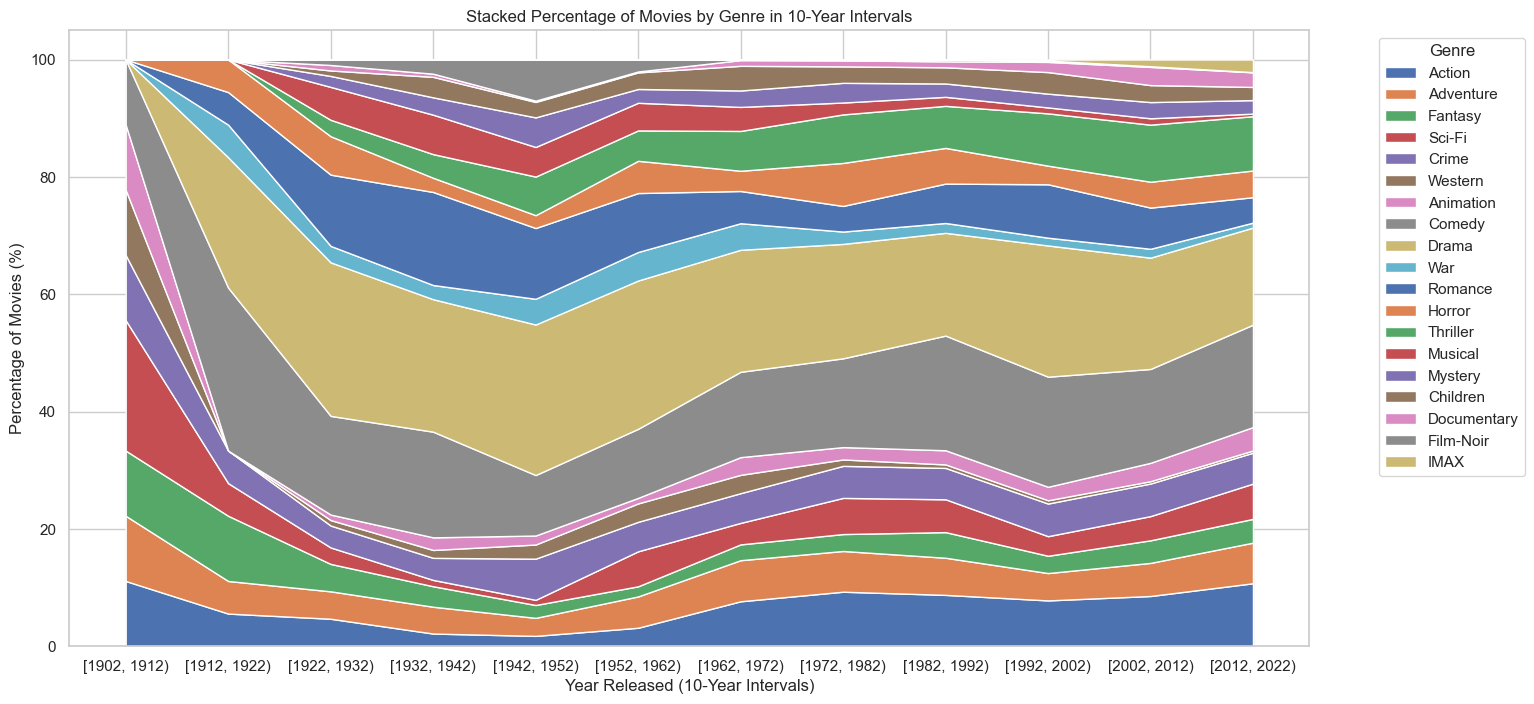

In [142]:
def stackplot_genres_per_10year(df, saving=False, filename=None):
    sns.set(style="whitegrid")
    df = df.sort_values("year_released")

    df = df[df["year_released"].notna()]

    #Create a range of 10-year intervals
    year_intervals = pd.cut(df["year_released"], bins=range(df["year_released"].min(), df["year_released"].max() + 11, 10), right=False)

    counts = []
    genres = df["genres"].str.split("|").explode().unique()

    for genre in genres:
        #Use observed=False to suppress the FutureWarning
        genre_counts = df[df["genres"].str.contains(fr'\b{genre}\b', na=False)].groupby(year_intervals, observed=False).size()     
        counts.append(genre_counts)

    counts_df = pd.concat(counts, axis=1, keys=genres).fillna(0)
    
    #Normalize the counts to get percentages
    counts_df = counts_df.div(counts_df.sum(axis=1), axis=0) * 100

    #Create a stackplot
    f, ax = plt.subplots(figsize=(16, 8))
    plt.stackplot(counts_df.index.astype(str), counts_df.T, labels=genres)
    
    plt.xlabel("Year Released (10-Year Intervals)")
    plt.ylabel("Percentage of Movies (%)")
    plt.title("Stacked Percentage of Movies by Genre in 10-Year Intervals")
    plt.legend(title="Genre", bbox_to_anchor=(1.05, 1), loc='upper left')  #Move legend outside the plot

    if saving:
        plt.savefig(filename, dpi=200, bbox_inches="tight")

    plt.show()

stackplot_genres_per_10year(movies, saving=False, filename=None)

Calculating the 90th percentile (quantile).

In [143]:
m = merged_movies['vote_count'].quantile(0.90)
print(m)

27.0


We just wanna keep the movies with more m (27) votes, in a new dataframe called q_movies.

And then we are resetting the index to easier read the dataframe.

In [144]:
q_movies = merged_movies.copy().loc[merged_movies['vote_count'] >= m]
q_movies = q_movies.reset_index(drop=True)
q_movies

,movieId,title,genres,year_released,vote_count
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,215.0
1,2,Jumanji,Adventure|Children|Fantasy,1995,110.0
2,3,Grumpier Old Men,Comedy|Romance,1995,52.0
3,5,Father of the Bride Part II,Comedy,1995,49.0
4,6,Heat,Action|Crime|Thriller,1995,102.0
...,...,...,...,...,...
971,134130,The Martian,Adventure|Drama|Sci-Fi,2015,48.0
972,134853,Inside Out,Adventure|Animation|Children|Comedy|Drama|Fantasy,2015,43.0
973,139385,The Revenant,Adventure|Drama,2015,31.0
974,152081,Zootopia,Action|Adventure|Animation|Children|Comedy,2016,32.0


We are calculating the average rating for each movie, and after that we are merging the merged_movies with average_ratings.

In [145]:
average_ratings = mvrt.groupby('movieId')['rating'].mean().reset_index()
average_ratings.columns = ['movieId', 'average_rating']

movies_average = pd.merge(merged_movies, average_ratings, on='movieId', how='left')
movies_average

,movieId,title,genres,year_released,vote_count,average_rating
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,215.0,3.920930
1,2,Jumanji,Adventure|Children|Fantasy,1995,110.0,3.431818
2,3,Grumpier Old Men,Comedy|Romance,1995,52.0,3.259615
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995,7.0,2.357143
4,5,Father of the Bride Part II,Comedy,1995,49.0,3.071429
...,...,...,...,...,...,...
9703,193581,Black Butler: Book of the Atlantic,Action|Animation|Comedy|Fantasy,2017,1.0,4.000000
9704,193583,No Game No Life: Zero,Animation|Comedy|Fantasy,2017,1.0,3.500000
9705,193585,Flint,Drama,2017,1.0,3.500000
9706,193587,Bungo Stray Dogs: Dead Apple,Action|Animation,2018,1.0,3.500000


We are calculating to see the average.

In [146]:
average_rating_of_all = movies_average['average_rating'].mean()
print(average_rating_of_all)

3.2620668706545675


In [147]:
q_movies = movies_average.copy().loc[merged_movies['vote_count'] >= m]
q_movies

,movieId,title,genres,year_released,vote_count,average_rating
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,215.0,3.920930
1,2,Jumanji,Adventure|Children|Fantasy,1995,110.0,3.431818
2,3,Grumpier Old Men,Comedy|Romance,1995,52.0,3.259615
4,5,Father of the Bride Part II,Comedy,1995,49.0,3.071429
5,6,Heat,Action|Crime|Thriller,1995,102.0,3.946078
...,...,...,...,...,...,...
8874,134130,The Martian,Adventure|Drama|Sci-Fi,2015,48.0,4.000000
8895,134853,Inside Out,Adventure|Animation|Children|Comedy|Drama|Fantasy,2015,43.0,3.813953
8984,139385,The Revenant,Adventure|Drama,2015,31.0,3.903226
9210,152081,Zootopia,Action|Adventure|Animation|Children|Comedy,2016,32.0,3.890625


Creating a histogram of average rating for each movie and counts, to visualise it. Notice that its almost a normal distribution curve.

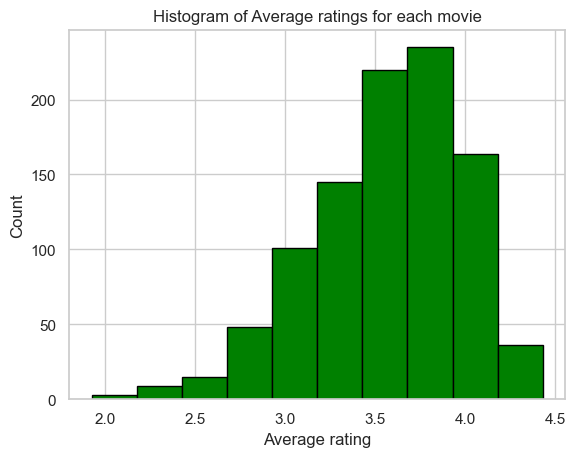

In [148]:
plt.hist(q_movies['average_rating'], bins=10, edgecolor='black', color='green')
plt.xlabel('Average rating')
plt.ylabel('Count')
plt.title('Histogram of Average ratings for each movie')
plt.show()

The histogram shows that most of the movies have an average rating between 3 and 4.5.

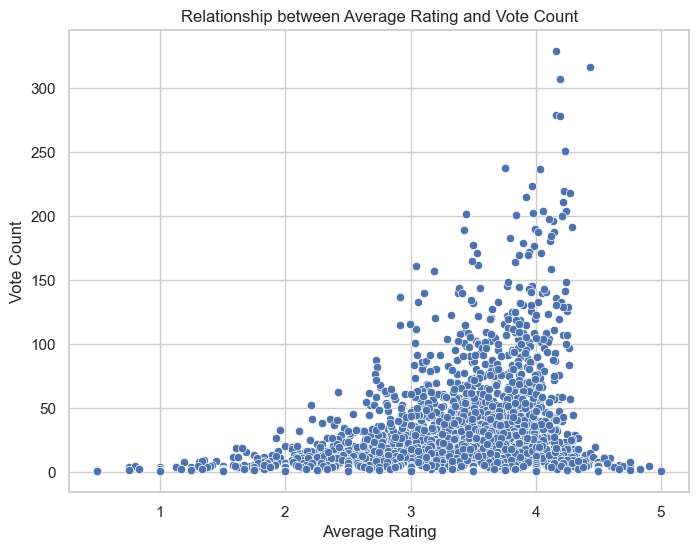

In [657]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='average_rating', y='vote_count', data=movies_average)
plt.title('Relationship between Average Rating and Vote Count')
plt.xlabel('Average Rating')
plt.ylabel('Vote Count')
plt.show()

This Scatterplot shows that movies that have an Average Rating in the extremities ie. 0-1 or close to 5 have very few votes and thus are not to be trusted

## Content-based recommender

We are creating a function to calculating the WAR weighted average rating.

In [149]:
def war(x, m=m, c=average_rating_of_all):
    v = x['vote_count']
    r = x['average_rating']
    return (v/(v+m) * r) + (m/(m+v) * c)

We are using the function on each of the movies and adding the scores to q_movies in a new column called score.

In [150]:
q_movies['score'] = movies_average.apply(war, axis=1)
print(q_movies['score'])

0       3.847421
1       3.398364
2       3.260453
4       3.139155
5       3.802913
          ...   
8874    3.734344
8895    3.601083
8984    3.604755
9210    3.602980
9413    3.593996
Name: score, Length: 976, dtype: float64


Checking the data in q_movies.

In [151]:
q_movies

,movieId,title,genres,year_released,vote_count,average_rating,score
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,215.0,3.920930,3.847421
1,2,Jumanji,Adventure|Children|Fantasy,1995,110.0,3.431818,3.398364
2,3,Grumpier Old Men,Comedy|Romance,1995,52.0,3.259615,3.260453
4,5,Father of the Bride Part II,Comedy,1995,49.0,3.071429,3.139155
5,6,Heat,Action|Crime|Thriller,1995,102.0,3.946078,3.802913
...,...,...,...,...,...,...,...
8874,134130,The Martian,Adventure|Drama|Sci-Fi,2015,48.0,4.000000,3.734344
8895,134853,Inside Out,Adventure|Animation|Children|Comedy|Drama|Fantasy,2015,43.0,3.813953,3.601083
8984,139385,The Revenant,Adventure|Drama,2015,31.0,3.903226,3.604755
9210,152081,Zootopia,Action|Adventure|Animation|Children|Comedy,2016,32.0,3.890625,3.602980


Saving q_movies and mvrt in a csv file to use for Streamlit later.

In [152]:
current_directory = os.getcwd()
#q_movies.to_csv(current_directory + '/q_movies.csv', index=False)
#mvrt.to_csv(current_directory + '/year.csv', index=False)

In [153]:
q_movies = q_movies.sort_values('score', ascending=False)

q_movies[['title', 'vote_count', 'average_rating', 'score']].head(15)

,title,vote_count,average_rating,score
277,"Shawshank Redemption, The",317.0,4.429022,4.337430
659,"Godfather, The",192.0,4.289062,4.162447
2226,Fight Club,218.0,4.272936,4.161534
224,Star Wars: Episode IV - A New Hope,251.0,4.231076,4.136963
46,"Usual Suspects, The",204.0,4.237745,4.123705
257,Pulp Fiction,307.0,4.197068,4.121484
461,Schindler's List,220.0,4.225000,4.119740
1939,"Matrix, The",278.0,4.192446,4.110085
898,Star Wars: Episode V - The Empire Strikes Back,211.0,4.215640,4.107461
314,Forrest Gump,329.0,4.164134,4.095719


Printed the top 15 movies, based on score.

In [154]:
movies['score'] = q_movies['score']
movies

,movieId,title,genres,year_released,score
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,3.847421
1,2,Jumanji,Adventure|Children|Fantasy,1995,3.398364
2,3,Grumpier Old Men,Comedy|Romance,1995,3.260453
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995,NaN
4,5,Father of the Bride Part II,Comedy,1995,3.139155
...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic,Action|Animation|Comedy|Fantasy,2017,NaN
9738,193583,No Game No Life: Zero,Animation|Comedy|Fantasy,2017,NaN
9739,193585,Flint,Drama,2017,NaN
9740,193587,Bungo Stray Dogs: Dead Apple,Action|Animation,2018,NaN


In [155]:
tfidf = TfidfVectorizer(stop_words='english')

Filling everthing that is null or NaN.

In [156]:
movies['genres'] = movies['genres'].fillna('')
movies['score'] = movies['score'].fillna(0)

In [157]:
movies[movies['title'] == 'Shawshank Redemption, The']

,movieId,title,genres,year_released,score
277,318,"Shawshank Redemption, The",Crime|Drama,1994,4.33743


In [158]:
#for streamlit
#¢unique_genres_moviest.to_csv(current_directory + '/unique_genres_movies.csv', index=False)

Converting the genres into vectors.

In [159]:
tfidf_matrix = tfidf.fit_transform(movies['genres'])

In [160]:
tfidf_matrix.shape

(9708, 21)

In [161]:
# Compute the cosine similarity matrix for each vs each genre
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim.shape

(9708, 9708)

In [162]:
#see the cosine matrix (or some of it)
print(cosine_sim)

[[1.         0.8136036  0.15259961 ... 0.         0.42114166 0.26738778]
 [0.8136036  1.         0.         ... 0.         0.         0.        ]
 [0.15259961 0.         1.         ... 0.         0.         0.57070525]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.42114166 0.         0.         ... 0.         1.         0.        ]
 [0.26738778 0.         0.57070525 ... 0.         0.         1.        ]]


In [163]:
indices = pd.Series(movies.index, index=movies['genres']).drop_duplicates()
indices

genres
Adventure|Animation|Children|Comedy|Fantasy       0
Adventure|Children|Fantasy                        1
Comedy|Romance                                    2
Comedy|Drama|Romance                              3
Comedy                                            4
                                               ... 
Action|Animation|Comedy|Fantasy                9737
Animation|Comedy|Fantasy                       9738
Drama                                          9739
Action|Animation                               9740
Comedy                                         9741
Length: 9708, dtype: int64

In [164]:
def get_recommendations(genre, cosine_sim=cosine_sim):
        # Get the indices of movies with the specified genre
        genre_list = genre.split('|')
        sorted_genre_list = sorted(genre_list)
        separator = '|'
        genre = separator.join(sorted_genre_list)
        genre_indices = indices[genre]

        # Initialize an empty list to store similarity scores
        sim_scores = []

        # Iterate over the genre indices and get the cosine similarity scores
        for idx in genre_indices:
            sim_scores.extend(list(enumerate(cosine_sim[idx])))

        # Sort the movies based on the similarity scores
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # Get the scores of the 10 most similar movies
        sim_scores = sim_scores[1:10]

        # Get the movie indices
        movie_indices = [i[0] for i in sim_scores]

        # Return the top 10 most similar movies
        genre_list = genre.split('|')
        movies_with_score = movies[['title', 'genres', 'score']].iloc[movie_indices]
        sorted_genre_list = sorted(genre_list)
        filtered_movies = movies[(movies['score'] > 0) & movies['genres'].apply(lambda x: all(genre in x for genre in sorted_genre_list))]
        sorted_movies = filtered_movies.sort_values(by='score', ascending=False)
        return sorted_movies.drop_duplicates(subset='title').head(5)

In [165]:
get_recommendations('Film-Noir')

,movieId,title,genres,year_released,score
951,1252,Chinatown,Crime|Film-Noir|Mystery|Thriller,1974,3.913672
1218,1617,L.A. Confidential,Crime|Film-Noir|Mystery|Thriller,1997,3.887708
695,913,"Maltese Falcon, The",Film-Noir|Mystery,1941,3.825011
704,922,Sunset Blvd. (a.k.a. Sunset Boulevard),Drama|Film-Noir|Romance,1950,3.797700
5850,32587,Sin City,Action|Crime|Film-Noir|Mystery|Thriller,2005,3.712395


## Collaborative filtering recommender

In [172]:
# Split the data into train and test sets, and then use only the train set
mvrt_train=mvrt
# Count the number of ratings per user
user_rating_counts = mvrt_train['userId'].value_counts()

# Filter out users with less than 10 ratings
valid_users = user_rating_counts[user_rating_counts >= 25].index

# Filter the original dataframe to keep only the ratings from valid users
mvrt_filtered = mvrt_train[mvrt_train['userId'].isin(valid_users)]

num_unique_users = mvrt_filtered['userId'].nunique()

print("Number of unique user IDs:", num_unique_users)

Number of unique user IDs: 547


(100789, 8)


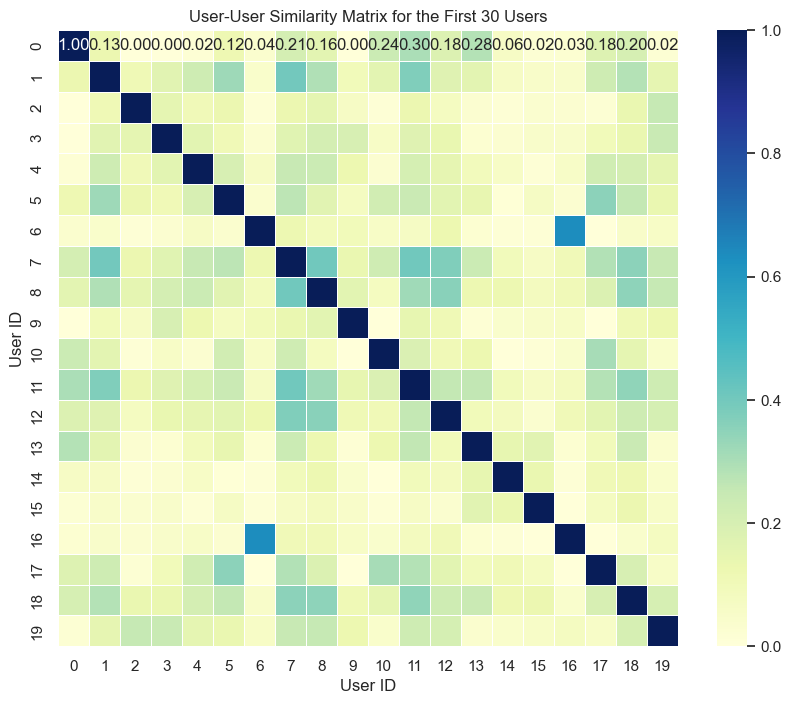

In [167]:
# Pivot the data to create a user-item matrix
user_movie_matrix = mvrt_filtered.pivot_table(index='userId', columns='movieId', values='rating', fill_value=0)

# Convert the DataFrame to a numpy array
user_movie_array = user_movie_matrix.to_numpy()

train_data, test_data = train_test_split(user_movie_array, test_size=0.3, random_state=42)

data = train_data

print(mvrt.shape)
class CollaborativeFilteringRecommender:
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors
        self.user_similarity = None

    def fit(self, train_data):
        # Compute user-user similarity matrix using cosine similarity
        self.user_similarity = cosine_similarity(train_data)
        plt.figure(figsize=(10, 8))
        subset_similarity_matrix = self.user_similarity[:20, :20]

        sns.heatmap(subset_similarity_matrix, cmap="YlGnBu", annot=True, fmt=".2f", linewidths=.5)
        plt.xlabel("User ID")
        plt.ylabel("User ID")
        plt.title("User-User Similarity Matrix for the First 30 Users")
        plt.show()

    def predict(self, user_indices, train_data):
        # Compute weighted average of ratings from similar users for each user index
        recommendations = []
        for user_index in user_indices:
            user_sim_scores = self.user_similarity[user_index]
            top_sim_users = np.argsort(user_sim_scores)[-self.n_neighbors - 1:-1]  # Exclude the user itself

            user_ratings = train_data[top_sim_users, :]
            user_sim_scores = user_sim_scores[top_sim_users]

            # Weighted average of ratings from similar users
            pred_ratings = np.dot(user_sim_scores, user_ratings) / np.sum(user_sim_scores)
            recommendations.append(pred_ratings)

        return recommendations

# Instantiate the recommender system
recommender = CollaborativeFilteringRecommender(n_neighbors=60)

# Train the recommender system
recommender.fit(data)

# Make recommendations for specified user indices
user_indices = [4,8]
recommendations = recommender.predict(user_indices, data)

Printing the titles of 3 movies the user likes and 3 recommended movies.

In [168]:
for i, user_index in enumerate(user_indices):
    print(f"User {user_index}:")
    print("     Known positives:")
    known_positives = mvrt[(mvrt['userId'] == user_index) & (mvrt['rating'] > 4)].nlargest(3, 'rating')
    for _, row in known_positives.iterrows():
        print("             %s" % row['title'])
    
    print("     Recommended:")
    for item_index in recommendations[i].argsort()[-3:][::-1]:
        movie_id = mvrt['movieId'].unique()[item_index]
        movie_title = mvrt[mvrt['movieId'] == movie_id]['title'].iloc[0]
        pred_rating = recommendations[i][item_index]  # Predicted rating for the recommended movie
        print("             %s (Predicted Rating: %.2f)" % (movie_title, pred_rating))


User 4:
     Known positives:
             Star Wars: Episode IV - A New Hope
             Fugitive, The
             Silence of the Lambs, The
     Recommended:
             Fast Times at Ridgemont High (Predicted Rating: 3.97)
             Ex Machina (Predicted Rating: 3.94)
             Four Weddings and a Funeral (Predicted Rating: 3.91)
User 8:
     Known positives:
             Usual Suspects, The
             Schindler's List
             Dances with Wolves
     Recommended:
             Ex Machina (Predicted Rating: 4.11)
             Winnie the Pooh and the Honey Tree (Predicted Rating: 4.10)
             Four Weddings and a Funeral (Predicted Rating: 3.98)


## Evaluation

In [169]:
# Make predictions for the test set
test_predictions = recommender.predict(range(len(test_data)), train_data)

# Calculate mean squared error
mse = mean_squared_error(test_data, test_predictions)
print("Mean Squared Error:", mse)
# Calculate mean absolute error
mae = mean_absolute_error(test_data, test_predictions)
print("Mean Absolute Error:", mae)

Mean Squared Error: 0.27331137799514815
Mean Absolute Error: 0.14952345175781387


Mean squared error (MSE) can be affected by movies that the user hasn't rated in the test set, since there's no ground truth to compare the predicted rating against. This is a common challenge in recommendation systems evaluation, known as the "cold start problem".

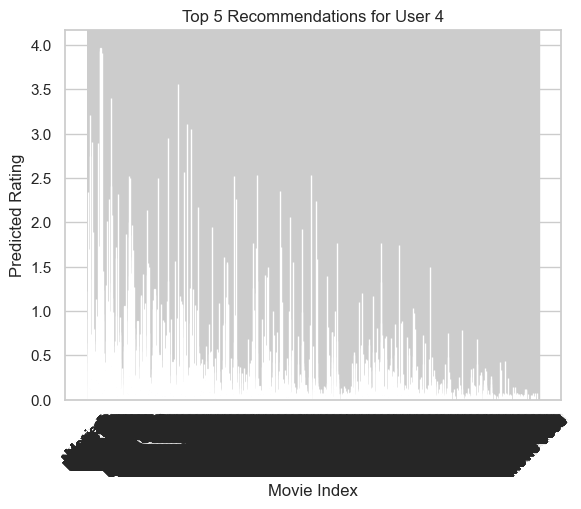

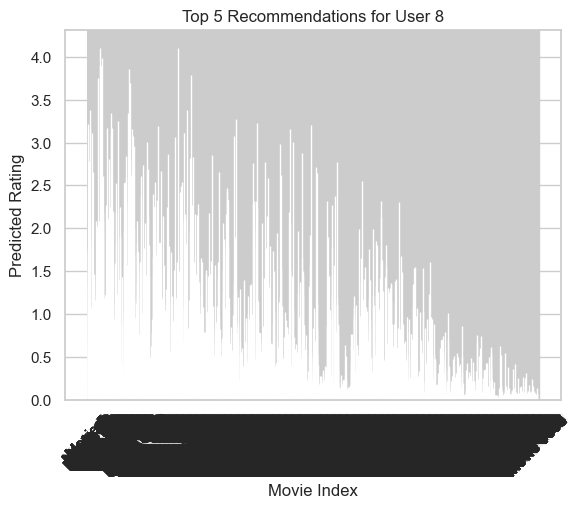

In [76]:
for i, user_index in enumerate(user_indices):
    top_n=5
    fig, ax = plt.subplots()
    ax.bar(range(len(recommendations[i])), recommendations[i])
    ax.set_xlabel('Movie Index')
    ax.set_ylabel('Predicted Rating')
    ax.set_title(f'Top {top_n} Recommendations for User {user_index}')
    ax.set_xticks(range(len(recommendations[i])))
    ax.set_xticklabels([f'Movie {j}' for j in range(1, len(recommendations[i]) + 1)], rotation=45)
    plt.show()